# Clasificación de imágenes empleando el dataset Fashion MNIST

### Marc Balle Sánchez

### Introducción

Durante la realización de esta práctica se pretende combinar herramientas clásicas de la visión por computador con algoritmos de _machine learning_. Así pues, existen dos partes bien diferenciadas: 
* Una primera parte donde se calculan las matrices GLCM ( _Gray level co-occurrence matrix_ ) y los histogramas HOG ( _histogram of gradients_ ) de cada imagen. Además, a partir de las GLCM se extraen medidas de texturas. En particular, todas aquellas que permite la librería ```skimage```. 
* Una segunda parte en la cual se emplean cada uno de los tres conjuntos de caratcerísticas para entrenar un modelo KNN ( _K Nearest Neighbours_ ) y posteriormente realizar una clasificación sobre imágenes nuevas. 

Para realizar todo el ejercicios se hace uso del dataset Fashion MNIST proporcionado por Zalando, el cual consta de unas 70000 imágenes (60000 de entrenamiento y 10000 de test). En cada imagen aparece un artículo de moda perteneciente a una de las 10 clases posibles de estos. Para la realización de esta práctica se ha limitado el número de clases a 5, las cuales se expondrán en el desarrollo de la práctica. 

### Comienzo de la práctica

Primero de todo se importan aquellas librerías necesarias para la realización del ejericio. 

In [1]:
import cv2 
import os
import gzip
import copy 
import random
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.feature.texture import greycomatrix, greycoprops

A continuación se define la función que permitirá cargar el conjunto de entrenamiento y de test directamente del repositorio clonado de Zalando. Esta función ya se incluía en el archivo ```utils/mnis_reader.py``` del mismo repositorio. 

In [2]:
def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Se cargan el conjunto de entrenamiento y de test. Además, se guardan las etiquetas de cada imagen. 

In [3]:
path = '../data/fashion'

X_train_orig, y_train_orig = load_mnist(path, kind='train')
X_test_orig, y_test_orig = load_mnist(path, kind = 't10k')

Se comprueba el formato en el que las imágenes son cargadas. Como puede observarse, el conjunto de entrenamiento consta de 60000 filas (una por imagen) y 784 columnas. Estas columnas las conforman cada unos de los píxeles de la imagen dispuestos como un vector fila. Se sabe que es así ya que, según la información que proporciona Zalando en el repositorio original del dataset, cada imagen tiene un tamaño 28x28, lo que suma un total de 784 píxeles por imagen. Como puede comoprobarse, sucede lo mismo con el conjunto de test.

In [6]:
X_train_orig.shape, X_test_orig.shape

((60000, 28, 28), (10000, 28, 28))

Así pues, se supone en un principio que las imágenes se encuentran ordenadas en cada fila. Es decir, cada 28 píxeles se tiene una fila de cada imagen. Bajo este supuesto, se reordenan las matrices iniciales para obtener las imágenes en un formato correcto y de fácil acceso. Se propone así matriz 3D donde cada capa constituye una imagen 28x28.

In [7]:
width = 28
height = 28

X_train_orig = np.reshape(X_train_orig, (60000, width, height))
X_test_orig = np.reshape(X_test_orig, (10000, width, height))

Se realiza una copia de cada uno de los conjuntos y sus etiquetas. La razón de ello es que más adelante se emplea la función ```graycomatrix``` para obtener la matriz GLCM, la cual requiere realizar algunas modificaciones sobre el conjunto de imágenes pasado. No obstante las imágenes iniciales no permiter la escritura, solo la lectura. Es por ello que se realizan unas copias, para evitar dicho error. 

In [8]:
X_train_total = copy.deepcopy(X_train_orig)
X_test_total = copy.deepcopy(X_test_orig)

y_train_total = copy.deepcopy(y_train_orig)
y_test_total = copy.deepcopy(y_test_orig)

Se comprueba por si acaso que no ha habido ninguna alteración en el formato

In [9]:
X_train_total.shape, X_test_total.shape

((60000, 28, 28), (10000, 28, 28))

A continuación se define la función ```create_set``` que permite crear conjuntos de entrenamiento y test reducidos y balanceados. Como ya se ha comentado, en esta práctica solos se emplearán 5 clases de artículos. Además se requiere que para cada clase haya el mismo número de imágenes dentro del conjunto creado. Dicho número se especifica con el argumento ```num```. 

Así pues, la selección de artículos se realiza de tal forma que se intenta escoger aquellos que no presenten grandes similitudes y resulta más fácil la tarea clasificatoria. Respecto a esto se han realizado dos pruebas: 

* Una primera prueba donde se ecogieron los 5 primeros artículos seleccionados. 
* Una segunda prueba donde se han seleccionado los artículos que se muestran en la función. 

Esta segunda selección sigue el criterio de intentas mantener la semejanza entre artículos baja, a diferencia de la primera que fue una selección arbitraria. No obstante, cabe mencionar que no se han observado grandes mejoras en los resultados. 

In [11]:
def create_set (X,labels, num):
    
    class1 = [a for a in range(0,labels.shape[0]) if labels[a] == 0] # T-shirt/top
    class2 = [b for b in range(0,labels.shape[0]) if labels[b] == 1] # Trouser
    class3 = [c for c in range(0,labels.shape[0]) if labels[c] == 3] # Dress
    class4 = [d for d in range(0,labels.shape[0]) if labels[d] == 5] # Sandal
    class5 = [f for f in range(0,labels.shape[0]) if labels[f] == 7] # Sneaker 
    
    class1_red = random.sample(class1, num)
    class2_red = random.sample(class2, num)
    class3_red = random.sample(class3, num)
    class4_red = random.sample(class4, num)
    class5_red = random.sample(class5, num)
    
    total = np.concatenate((class1_red,class2_red, class3_red, class4_red, class5_red))
    total = np.sort(total) #ordenamos en orden ascendente
    
    X_reduced = X[total]
    y_reduced = labels[total]
    
    return X_reduced, y_reduced

Se forman los conjuntos de entrenamiento y de test. Para el conjunto de entrenamiento se seleccionan 200 imágenes por clase, mientras que para el de test 40. Así pues, la proporción entrenamiento-test sobre el total de imágenes escogidas es aporoximadamente 83%-17%, respectivamente. 

In [12]:
X_train, y_train = create_set(X_train_total, y_train_total, 200) # Un 83% de train
X_test, y_test = create_set(X_test_total, y_test_total, 40) # Un 17 % de test

Se comprueba que la selección de los conjuntos sea coherente con las dimensiones deseadas. 

In [14]:
print('Tamaño X train: ', X_train.shape,'\n',
      'Tamaño X test: ', X_test.shape)

Tamaño X train:  (1000, 28, 28) 
 Tamaño X test:  (200, 28, 28)


A continuación se realiza una pequeña prueba visual para comprobar que las etiquetas y las imágenes coinciden y no se ha perdido el formato. Esto se realiza para ambos conjuntos.

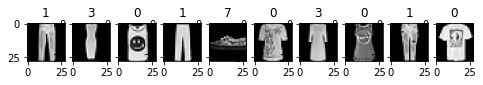

In [15]:
fig, ax = plt.subplots(1,10, figsize = (8,8))

for i in range(0,10): 
    ax[i].imshow(X_train[i], cmap = 'gray')
    ax[i].set_title(str(y_train[i]))
    

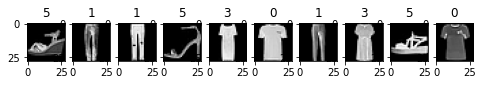

In [16]:
fig2, ax2 = plt.subplots(1,10, figsize = (8,8))

for j in range(0,10): 
    ax2[j].imshow(X_test[j], cmap = 'gray')
    ax2[j].set_title(str(y_test[j]))

Efectivamente existe concordancia entre las matrices de imágenes y los vectores que almancenan sus etiquetas. De esta forma, ya se disponen de los conjuntos de datos en el formato adecuado, así que puede procederse a la extracción de características. 

## Matrices GLCM y medidas de textura

#### ¿Qué es la matriz GLCM? 

La matriz GLCM almacena la información sobre la frecuencia con la que se dan ciertas combinaciones de niveles de gris en una imagen o ventana de esta. Para crear la matriz GLCM deben especificarse ciertos aspectos: 
* Distancia a la cual se quieren observar las correspondencias. Esto es, si se quieren considerar píxeles vecinos, o aquellos que están a una distancia superior a 1 píxel. 
* Dirección en la cual analizar las correspondencias. Por ejemplo, pueden considerarse únicamente relaciones entre un píxel y aquel situado a una distancia X a su derecha, o abajo, etc. 
* Simetría y normalización. Una vez obtenida la matriz GLCM, esta puede hacerse simétrica sumándole su traspuesta. Además, si queremos que esta tenga forma de distribución de probabilidad, se puede normaliar cada celda dividiendo su valor por la suma de valores totales de la matriz. 

Una vez se ha obtenido la matriz, se pueden obtener diferentes medias de textura a partir de ella. Básicamente, toda estas consisten en medias ponderadas de los valores de la matriz o histograma. 

Una vez explicado brevemente qué es la matriz GLCM, se procede a calcularla por cada imagen, así como la obtención de las medidas de texturas que ofrece la librería ```skimage``` a partir de dicha matriz. 

Para la obtención de la matriz GLCM se hace uso de ```greycomatrix```. En su llamada se especifican los aspectos anteriormente mencionados. En este caso solo se comprueba el píxel de la derecha (ángulo 0 radianes) y el más cercano (distancia 1 píxel) en cada uno de los píxeles de la imagen (menos en los que conforman el borde derecho). Además se obtiene la matriz simétrica y normalizada por cada imagen. 

Una vez obtenida la matriz GLCM, se hace uso de la función ```greycoprops``` para obtener las distintas medidas de textura. 

Todos estos resultados se almacenan en matrices. Las matrices GLCM tendrán dimensión 256x256 (todos los valores de gris posibles en imágenes uint8). Estas se van a amontonar en matrices 3D donde cada capa conforme la matriz GLCM de una imagen.  Las medidas de textura se almacenarán en columnas (una por medida) y por filas (una por imagen). 

Cabe mencionar que la función ```graycomatrix``` permite evaluar las combinaciones de grises en distintas distancias y direcciones. Sin embargo, por cuestiones de tiempo y simplicidad, solo se optan por los valores ya mencionados. 

Finalmente se destaca que, al tratarse de imágenes pequeñas, solo se obtiene una matriz GLCM por imagen, y por ende solo se puede extraer un valor por medida de textura por imagen. Así que cada imagen quedará representada por una matriz GLCM y por 6 medidas de textura. Posteriormente se discutirá la repercusión que esto puede tener en la clasificación. 

#### Conjunto de entrenamiento 

In [22]:
train_size = X_train.shape[0]

glcm_train = np.zeros((train_size, 256, 256)) # matrices GLCM agrupadas
glcm_params_train = np.zeros((train_size, 6)) # 6 medidas de textura por imagen
i = 0

for img in X_train:
    glcm = greycomatrix(img, distances = [1], angles = [0], symmetric= True, normed = True) #glcm para toda la imagen
    
     # Se guarda la glcm de la imagen. Se eliminan las dos dimensiones restantes ya que corresponden
     # al número de ángulos y distancias evaluados. En este caso, al ser los dos 1, no hace falta incluirlos. 
    glcm_train[i] = np.reshape(glcm, (glcm.shape[0:2])) 
    
    glcm_params_train[i, 0] = np.reshape(greycoprops(glcm, 'contrast'), (1,)) 
    glcm_params_train[i, 1] = np.reshape(greycoprops(glcm, 'homogeneity'), (1,))
    glcm_params_train[i, 2] = np.reshape(greycoprops(glcm, 'energy'), (1,))
    glcm_params_train[i, 3] = np.reshape(greycoprops(glcm, 'correlation'), (1,))  
    glcm_params_train[i, 4] = np.reshape(greycoprops(glcm, 'dissimilarity'), (1,))
    glcm_params_train[i, 5] = np.reshape(greycoprops(glcm, 'ASM'), (1,))
    
    

    i+=1

#### Conjunto de test

In [23]:
test_size = X_test.shape[0]

glcm_test = np.zeros((test_size, 256, 256)) # matrices GLCM agrupadas
glcm_params_test = np.zeros((test_size, 6)) # 4 medidas de la GLCM (iniciales) + 2 extra
i = 0

for img_t in X_test:
    glcm_t = greycomatrix(img_t, distances = [1], angles = [0], symmetric= True, normed = True) #glcm para toda la imagen
    
    glcm_test[i] = np.reshape(glcm_t, (glcm_t.shape[0:2])) # se guarda la glcm de la imagen
    
    glcm_params_test[i, 0] = np.reshape(greycoprops(glcm_t, 'contrast'), (1,)) #quizás haga falta un reshape a 1,
    glcm_params_test[i, 1] = np.reshape(greycoprops(glcm_t, 'homogeneity'), (1,))
    glcm_params_test[i, 2] = np.reshape(greycoprops(glcm_t, 'energy'), (1,))
    glcm_params_test[i, 3] = np.reshape(greycoprops(glcm_t, 'correlation'), (1,))

    glcm_params_train[i, 4] = np.reshape(greycoprops(glcm_t, 'dissimilarity'), (1,))
    glcm_params_train[i, 5] = np.reshape(greycoprops(glcm_t, 'ASM'), (1,))
    
    i+=1


## HOG

#### ¿Qué es el HOG?

De forma muy breve, el HOG ( _histogram of oriented gradients_ ) es un vector que almacena información sobre los gradientes y direcciones de estos en diferentes subconjuntos de una imagen. A continuación se comentan algunos aspectos para comprender la implementación del HOG en esta práctica: 

* El vector o histograma resultante del HOG se calcula sobre ventanas de la imagen. El tamaño de estas ventanas viene definido por el parámetro ```winSize```. De nuevo, al tratarse de imágenes pequeñas, la ventana es toda la imagen. En este punto surgió una duda, y es que algunas fuentes recomiendan que el tamaño de la ventana guarde una relación 1:2 en cuanto a ancho y alto. Sin embargo, aquí eso no se cumple, y se desconocen cuáles pueden ser los efectos de no hacerlo. 

* La ventana seleccionada se divide en celdas de un determinado tamaño. Dentro de estas celdas se calcularán la magnitud y gradiente por cada píxel. Esta información se almacena en un histograma, donde cada barra representa una dirección y la altura de cada barra es proporcional a las magnitudes de los gradientes próximos o coincidentes con el ángulo representado en la barra. El tamaño de las celdas se define el ```cellSize```, y se escogen celdas cuadradas 4x4. El número de direcciones tomadas en consideración viene definido por el parámetro ```nbins```. 

* Una vez se han obtenido todos los histogramas, se procede a normalizarlos. Este paso es necesario para convertir al descriptor HOG invariante a cambios en el brillo. Para normalizarlo, se toman en cuenta los histogramas de un conjunto de celdas. La cantidad de celdas incluidas en cada paso de la normalización viene definido por el parámetro ```blockSize```. En este caso, y siguiendo la recomendación encontrada en diferentes fuentes, se escoge un tamaño el doble de la celdas. Así pues, cada bloque engloba 4 celdas, es decir, 4 histogramas. Para normalizar, se concatenan los histogramas en un solo vector y se divide cada componente de este por el módulo del histograma concatenado. Esto es igual forma que sucede con los vectores normales. 
* Finalmente, este bloque de normalización se va deslizando por la imagen hasta haberla recorrido entera. Para ello tiene que definirse el paso en número de píxeles que realiza cada vez. En este caso se establece que dicho bloque se mueva 4 píxeles a la derecha y 4 píxeles hacia abajo. Es decir, el tamaño de una celda. 
* El resto de parámetros se deja por defecto. Entre estos cabe destacar el ```signedGradients``` donde se indica si se tiene en cuenta los signos en la dirección del gradiente. Al establecerlo como ```False```, se está indicando que un gradiente con dirección 0 grados y otro de 180 grados poseen la misma dirección. 

Se incicializa el objeto que permitirá calcular el HOG de cada imagen.

In [17]:
# Parámetros ajustados al tamaño de la imagen de entrada
winSize = (width, height) 
blockSize = (8,8) # el doble que el tamaño de la celda
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
# Parámetros por defecto
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = False

#Se inicializa el objeto HOG
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,
                        derivAperture,winSigma,histogramNormType,L2HysThreshold,
                        gammaCorrection,nlevels, signedGradients)

Se realiza una prueba rápida para comprobar el vector resultante (o histograma) es coherente con el número de dimensiones esperado. 

In [18]:
hog_prueba = hog.compute(X_train[0])

In [19]:
hog_prueba.shape

(1296, 1)

Sale razonable, ya que tenemos histogramas de 9x1 por cada celda 4x4, es decir en cada bloque 8x8 tenemos un histograma 36x1. Hay 6 posiciones horizontales para los bloques 8x8, y 6 verticales; en total 36 posiciones. Así pues el vector o histograma resultante tiene que tener dimensión 36x36 = 1296x1.

Se prodecen a calcular los HOG por cada conjunto de imágenes. Los resultados se almacenarán en matrices donde cada fila corresponderá con una imagen distinta.

Para la obtención del HOG se hace uso de la función ```hog.compute()```

#### Conjunto de entrenamiento

In [24]:
hog_train = np.zeros((train_size, 1296))
i=0

for img3 in X_train: 
    hog_train[i] = np.reshape(hog.compute(img3), (1296,))
    i+=1

#### Conjunto de test

In [25]:
hog_test = np.zeros((test_size, 1296))
i=0

for img4 in X_test: 
    hog_test[i] = np.reshape(hog.compute(img4),(1296,))
    i+=1

## Clasificación con K-Nearest Neighbours 

En esta última parte se entrena un algoritmo KNN para posteriormente clasificar el conjunto de imágenes de test. Para ello, se van a emplear los tres descriptores por separado y comparar cuál funciona mejor. Además se usan distintas distancias para correr el algoritmo KNN y comprobar la influencia de estas. Como métricas para la evaluación de los modelos se emplea el _accuracy_ , la precisión, el _recall_ y la _f1_. Así se obtiene una visión un poco más completa del funcionamiento del modelo que solo empleando el _accuracy_ . Finalmente también se dibujarán las tablas de confusión. 

Primero de todo se importan las librerías necesarias. 

In [26]:
import math
from sklearn import  metrics
from sklearn.neighbors import KNeighborsClassifier

A continuación se definen distintos métodos para el cálculo de distancias entre histogramas. Es cierto que OpenCV posee el método ```compareHist()``` para dichos cálculos. Sin embargo, en este caso esta función daba problemas al emplearla con los datos tal y como se disponen. Se sospecha que existe algún problema con el formato en el que se almacenan, ya que dicha función si que funciona cuando se le introduce el histograma directamente resultante de la función ```hog.compute()```, como se verá más adelante.

Nótese también que se ha evitado el uso de bucles ```for``` o similares, lo cual ralentizaría mucho la ejecución de estas funciones y, por lo tanto, el entrenamiento y la clasificación (esto se ha comprobado).

#### Correlación entre histogramas

Esta es una medida de similaritud, no de disimilaritud como la distancia. Es por ello que lo más probable es que funcione mal con el algoritmo KNN, el cual emplea métricas de disimilaritud. Sin embargo, quería comprobarse qué pasaba al usar la correlación. 

In [33]:
def distCorr (h1, h2): 
    h1_mean = np.mean(h1)
    h2_mean = np.mean(h2)
    
    num = 0
    den = 0
    
    h1_zero = h1 - h1_mean
    h2_zero = h2 - h2_mean
    
    h1_h2_zero = np.multiply(h1_zero,h2_zero)
    num = np.sum(h1_h2_zero)
    
    h1_zero_sq = np.sum(np.square(h1_zero))
    h2_zero_sq = np.sum(np.square(h2_zero))
    
    den = math.sqrt(h1_zero_sq*h2_zero_sq)
        
    return num/den

#### Distancia de Bhattacharyya

In [28]:
def distBhatt (h1, h2): 
    h1_mean = np.mean(h1)
    h2_mean = np.mean(h2)
    bins = h1.shape[0]
    
    summ = 0
    
    h1_sqrt = np.sqrt(h1)
    h2_sqrt = np.sqrt(h2)
    h1_h2 = np.multiply(h1_sqrt, h2_sqrt)
    num = np.sum(h1_h2)
    
    
    scale = 1/(math.sqrt(h1_mean*h2_mean*(bins**2)))
    
    return math.sqrt(1-scale*num)

#### Distancia Chi Square

En esta distancia tuvo que hacerse una pequeña modificación. Y es que, al incluir una división por cada valor del ```h1``` (histograma número 1), puede darse una división por cero si este posee elementos con dicho valor. Por eso, para evitar el error, se establece que dichas divisiones devuelvan un valor 0.

Un valor de cero en los HOG equivaldría a que el ángulo de ningún gradiente en alguna celda recae en un determinado intervalo de valores angulares, por lo que no contribuye a alguno de los bins del histograma. En cuanto al GLCM, basta con que no se de una determinada combinación de valores de gris en la imagen, lo cual viendo las imágenes que se tienen (escasa variabilidad en los valores de gris), no es raro que suceda. 

In [29]:
def chiSquare (h1,h2): 
    #elimino los ceros para no causar un error al dividir por cero.
    #Esto es lo mismo que decir que la división por cero devuelve un 0
    index = np.nonzero(h1) 
    h1 = h1[index]
    h2 = h2[index]
    chi_dist = np.sum(np.divide(np.square(h1 - h2),h1))
       
    return chi_dist

A continuación se realizan una pequeñas pruebas para cerciorarse de que estas funciones definidas devuelven los mismos valores que la definida por OpenCV y, por lo tanto, de que funcionan bien. Nótese que OpenCV sí funciona con los histogramas devueltos directamente por la función ```hog.compute()```


La correlación:

In [31]:
cv2.compareHist(hog.compute(X_train[0]), hog.compute(X_train[1]), cv2.HISTCMP_CORREL)

0.473249955338702

In [34]:
distCorr(hog_train[0], hog_train[1])

0.4732499553387017

La distancia de Bhattacharyya:

In [35]:
cv2.compareHist(hog.compute(X_train[0]), hog.compute(X_train[1]), cv2.HISTCMP_BHATTACHARYYA)

0.5355728311061186

In [36]:
distBhatt (hog_train[0], hog_train[1])

0.5355728311061186

Antes de comprobar la de Chi Square, se quiere también verificar que la división por cero en OpenCV devuelve 0. Por ello primero se comprueba si el ```h1```, en este caso el ```hog_train[0]``` posee algún 0 que provoque esta situación. 

In [40]:
if 0 in hog_train[0]:
    print(True)
else: 
    print(False)

True


In [41]:
cv2.compareHist(hog.compute(X_train[0]), hog.compute(X_train[1]), cv2.HISTCMP_CHISQR)

1028.531698757623

In [39]:
chiSquare(hog_train[0], hog_train[1])

1028.5317109707232

Se observa que todas ellas funcionan bien. Ya se puede proceder a realizar la clasificación.

## Usando las medidas obtenidas a partir del GLCM

#### Solo con las 4 primeras medidas de textura

Primero se emplean solo las 4 primeras medidas para posteriormente comparar con el uso de todas ellas. 

El clasificador se incializa a sus valores por defecto, entre los cuales son de interés el número de vecinos (5 vecinos) y la distancia empleada (la Euclídea). 

In [43]:
knn_glcm = KNeighborsClassifier() #default parameters

knn_glcm = knn_glcm.fit(glcm_params_train[:,0:4], y_train)

In [44]:
prediction_glcm = knn_glcm.predict(glcm_params_test[:,0:4])

Para las métricas de precisión, _recall_ y _f1_ se computa una media no ponderada por cada clase ( ```average = 'macro'```). En este caso no sería necesaria la ponderación por clases ya que todas ellas tiene misma representación en el conjunto de test. Por otra parte, al tratarse de una media, resulta un poco complicado realizar conclusiones sobre el comportamiento del algoritmo por cada una de clases (en lo que respecta a estas métricas). 

In [45]:
acc_glcm = metrics.accuracy_score(y_test, prediction_glcm)
precision_glcm = metrics.precision_score(y_test, prediction_glcm, average = 'macro')
recall_glcm = metrics.recall_score(y_test, prediction_glcm, average = 'macro')
f1_glcm = metrics.f1_score(y_test, prediction_glcm, average = 'macro')

print ('Accuracy: ', acc_glcm, '\n',
       'Precision: ', precision_glcm,'\n',
       'Recall: ', recall_glcm, '\n', 
       'F1: ', f1_glcm)

Accuracy:  0.435 
 Precision:  0.43734848097638795 
 Recall:  0.43499999999999994 
 F1:  0.4339346171461176


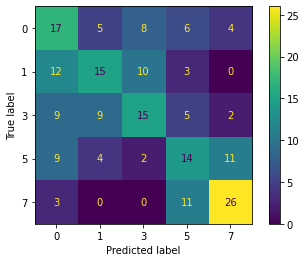

In [46]:
metrics.plot_confusion_matrix(knn_glcm, glcm_params_test[:,0:4], y_test);

#### Observaciones

Se aprecia que el clasificador es malo, con todas sus métricas por debajo de 0.5 y muy iguales entre ellas. A ver si empleando más características mejora. 

#### Con todas las medidas posibles a extraer de la GLCM empleando ```skimage```

Se emplea el mismo clasificador instanciado que antes. 

In [47]:
knn_glcm = knn_glcm.fit(glcm_params_train, y_train)

In [48]:
prediction_glcm = knn_glcm.predict(glcm_params_test)

In [49]:
acc_glcm = metrics.accuracy_score(y_test, prediction_glcm)
precision_glcm = metrics.precision_score(y_test, prediction_glcm, average = 'macro')
recall_glcm = metrics.recall_score(y_test, prediction_glcm, average = 'macro')
f1_glcm = metrics.f1_score(y_test, prediction_glcm, average = 'macro')

print ('Accuracy: ', acc_glcm, '\n',
       'Precision: ', precision_glcm,'\n',
       'Recall: ', recall_glcm, '\n', 
       'F1: ', f1_glcm)

Accuracy:  0.405 
 Precision:  0.41467984564907867 
 Recall:  0.4050000000000001 
 F1:  0.4054719937837521


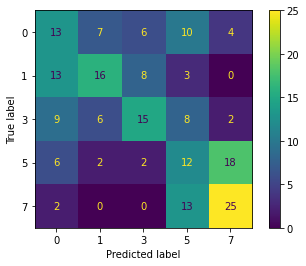

In [50]:
metrics.plot_confusion_matrix(knn_glcm, glcm_params_test, y_test);

#### Observaciones

Se observa que el hecho de haber incluido el resto de medidas no ha mejorado la clasificación, sino que la ha empeorado ligeramente. 

En general, podría decirse que en este problema las medidas de textura empleadas no son discriminantes. Este hecho puede deberse a varias razones: 
* El número de medidas por imagen es muy pequeño. Debido al reducido tamaño de las imágenes, solo puede obtenerse una medida de textura diferente por cada una de ellas. Así, cada imagen queda descrita únicamente por un vector de dimensión 6 (o 4 en el primer caso). 
* En imágenes de esta naturaleza, donde los niveles de gris no son muy variados ni tampoco hay muchas combinaciones posibles debido al reducido tamaño, las medidas extraídas de la matriz GLCM pueden perder su representabilidad y resultar poco significantes si se quieren captar los matices que de cada imagen. Además, la textura entre artículos puede no cambiar demasiado, y describir estos cambios con un solo valor en las medidas de textura puede ser pedir demasiado.

Finalmente mencionar que el hecho de incluir más medidas desemboque en peor clasificación, puede deberse al hecho de que las variables añadidas, la disimilaritud y la ASM, son parecidas al contraste y a la energía (ya añadidas a principio). Por eso, quizás esta información redundante, y más en este tipo de imágenes, puede resultar perjudicial. 

## Usando los HOG

### Empleando como métrica de distancia la correlación 

Primero de todo se evalúa el KNN con los valores por defecto ya comentados y la métrica de correlación como distancia. 

In [51]:
knn_hog_corr = KNeighborsClassifier(metric = distCorr) 

knn_hog_corr = knn_hog_corr.fit(hog_train, y_train)

In [52]:
prediction_hog_corr = knn_hog_corr.predict(hog_test)

In [53]:
acc_hog_corr = metrics.accuracy_score(y_test, prediction_hog_corr)
precision_hog_corr = metrics.precision_score(y_test, prediction_hog_corr, average = 'macro') 
recall_hog_corr = metrics.recall_score(y_test, prediction_hog_corr, average = 'macro')
f1_hog_corr = metrics.f1_score(y_test, prediction_hog_corr, average= 'macro')

print ('Accuracy: ', acc_hog_corr, '\n',
       'Precision: ', precision_hog_corr,'\n',
       'Recall: ', recall_hog_corr, '\n', 
       'F1: ', f1_hog_corr)

Accuracy:  0.015 
 Precision:  0.008695652173913044 
 Recall:  0.015 
 F1:  0.011009174311926604


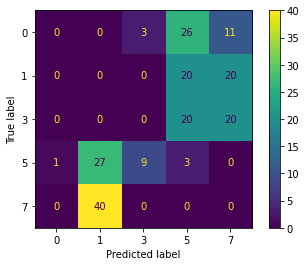

In [54]:
metrics.plot_confusion_matrix(knn_hog_corr, hog_test, y_test);

#### Observaciones

Tal y como se esperaba, funciona mal, ya que el KNN funciona con métricas de disimilaritud. 

### Empleando como métrica de distancia la de Bhattacharyya. 

In [55]:
knn_hog_bhat = KNeighborsClassifier(metric = distBhatt)

knn_hog_bhat = knn_hog_bhat.fit(hog_train, y_train)

In [56]:
prediction_hog_bhat = knn_hog_bhat.predict(hog_test)

In [57]:
acc_hog_bhat = metrics.accuracy_score(y_test, prediction_hog_bhat)
precision_hog_bhat = metrics.precision_score(y_test, prediction_hog_bhat, average = 'macro') 
recall_hog_bhat = metrics.recall_score(y_test, prediction_hog_bhat, average = 'macro')
f1_hog_bhat = metrics.f1_score(y_test, prediction_hog_bhat, average = 'macro')

print ('Accuracy: ', acc_hog_bhat, '\n',
       'Precision: ', precision_hog_bhat,'\n',
       'Recall: ', recall_hog_bhat, '\n', 
       'F1: ', f1_hog_bhat)

Accuracy:  0.945 
 Precision:  0.9481697684880059 
 Recall:  0.945 
 F1:  0.944693493028187


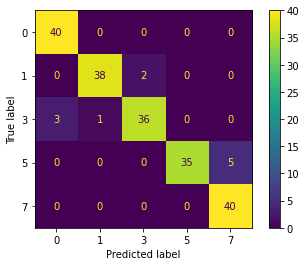

In [58]:
metrics.plot_confusion_matrix(knn_hog_bhat, hog_test, y_test);

#### Observaciones

Se comprueba que en este caso la clasificación es muy buena, con una _accuracy_ cerca del 95%. Este buen resultado podría atribuirse a que el HOG se "centra" en la forma que posee el objeto en la imagen, en esencia sus bordes. Uno puede concluir, observando visualmente los datos, que este factor resulta mucho más discriminante que la textura presente en las imágenes. Y eso se refleja en los resultados también. Por otra parte, el HOG permite describir la imagen con mayor definición que las medidas anteriores, ya que el histograma de cada imagen cuenta con una dimensión igual a 1296 valores. Sin embargo, hay que tener en cuenta que muchos de estos podrían ser ceros. 

### Distancia Chi Square

In [59]:
knn_hog_chi = KNeighborsClassifier(metric = chiSquare)

knn_hog_chi = knn_hog_chi.fit(hog_train, y_train)

In [60]:
prediction_hog_chi = knn_hog_chi.predict(hog_test)

In [61]:
acc_hog_chi = metrics.accuracy_score(y_test, prediction_hog_chi)
precision_hog_chi = metrics.precision_score(y_test, prediction_hog_chi, average = 'macro') 
recall_hog_chi = metrics.recall_score(y_test, prediction_hog_chi, average = 'macro')
f1_hog_chi = metrics.f1_score(y_test, prediction_hog_chi, average = 'macro')

print ('Accuracy: ', acc_hog_chi, '\n',
       'Precision: ', precision_hog_chi,'\n',
       'Recall: ', recall_hog_chi, '\n', 
       'F1: ', f1_hog_chi)

Accuracy:  0.645 
 Precision:  0.7190560938179986 
 Recall:  0.645 
 F1:  0.6279916073732874


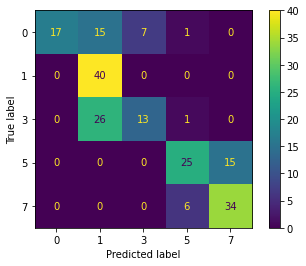

In [62]:
metrics.plot_confusion_matrix(knn_hog_chi, hog_test, y_test);

#### Observaciones

Parece que la distancia de Bhattacharyya funciona bastante mejor en este caso que la Chi Square.

### Empleando como métrica de distancia la Euclídea

En este caso se emplea la distancia Euclídea. Esta toma los histogramas como vectores numéricos normales a la hora del cálculo.

In [63]:
knn_hog_eu = KNeighborsClassifier() #default parameters

knn_hog_eu = knn_hog_eu.fit(hog_train, y_train)

In [64]:
prediction_hog_eu = knn_hog_eu.predict(hog_test)

In [65]:
acc_hog_eu = metrics.accuracy_score(y_test, prediction_hog_eu)
precision_hog_eu = metrics.precision_score(y_test, prediction_hog_eu, average = 'macro') 
recall_hog_eu = metrics.recall_score(y_test, prediction_hog_eu, average = 'macro')
f1_hog_eu = metrics.f1_score(y_test, prediction_hog_eu, average = 'macro')

print ('Accuracy: ', acc_hog_eu, '\n',
       'Precision: ', precision_hog_eu,'\n',
       'Recall: ', recall_hog_eu, '\n', 
       'F1: ', f1_hog_eu)

Accuracy:  0.935 
 Precision:  0.9395877774456778 
 Recall:  0.9349999999999999 
 F1:  0.9347415058513565


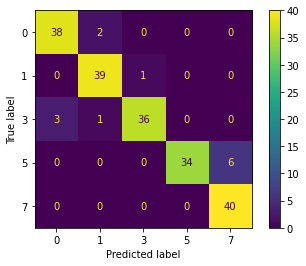

In [66]:
metrics.plot_confusion_matrix(knn_hog_eu, hog_test, y_test);

#### Observaciones

La distancia Euclídea permite una clasificación muy semejante, pero no mejor, a cuando se emplea la distancia de Bhattacharyya.

## Usando los histogramas GLCM

Antes de alimentar el KNN con los histograma GLCM, hay que ponerlos en el formato adecuado para el cálculo de distancias. Estos histogramas están almacenados en forma de matriz 256x256. Únicamente se procede a aplanarlos a una sola dimensión, tal y como los HOG. 

In [67]:
def flatten_glcm (glcm): 
    out = np.zeros((glcm.shape[0],glcm.shape[1]*glcm.shape[2]))
    i = 0
    for mat in glcm: 
        out[i] = mat.flatten()
        i += 1
    return out

In [68]:
glcm_train_flat = flatten_glcm(glcm_train)
glcm_test_flat = flatten_glcm(glcm_test)

Se comprueba que tienen las dimensiones correctas. 

In [71]:
glcm_train_flat.shape, glcm_test_flat.shape

((1000, 65536), (200, 65536))

#### Observación

Antes de todo mencionar que debido a la alta dimensionalidad de los histogramas GLCM, el tiempo de cómputo de las distancias son mayores, y por lo tanto el tiempo de entrenamiento y test. 

### Empleando como métrica de distancia la de Bhattacharyya

In [72]:
knn_glcm_bhat = KNeighborsClassifier(metric = distBhatt)

knn_glcm_bhat = knn_glcm_bhat.fit(glcm_train_flat, y_train)

In [73]:
prediction_glcm_bhat = knn_glcm_bhat.predict(glcm_test_flat)

In [74]:
acc_glcm_bhat = metrics.accuracy_score(y_test, prediction_glcm_bhat)
precision_glcm_bhat = metrics.precision_score(y_test, prediction_glcm_bhat, average = 'macro') 
recall_glcm_bhat = metrics.recall_score(y_test, prediction_glcm_bhat, average = 'macro')
f1_glcm_bhat = metrics.f1_score(y_test, prediction_glcm_bhat, average = 'macro')

print ('Accuracy: ', acc_glcm_bhat, '\n',
       'Precision: ', precision_glcm_bhat,'\n',
       'Recall: ', recall_glcm_bhat, '\n', 
       'F1: ', f1_glcm_bhat)

Accuracy:  0.235 
 Precision:  0.2777807486631016 
 Recall:  0.23500000000000001 
 F1:  0.13104013705335293


/Users/MarcBalle/opt/anaconda3/envs/visio_per_computador/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


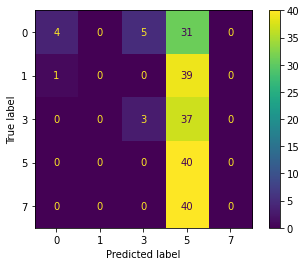

In [75]:
metrics.plot_confusion_matrix(knn_glcm_bhat, glcm_test_flat, y_test);

#### Observaciones

A diferencia de los histogramas HOG con la distancia de Bhattacharyya, los resultados con los GLCM son mucho peores. A priori, uno podría pensar dada la alta dimensionalidad de los vectores, la decripción de las imágenes es muy buena. No obstante, existe una alta cantidad de ceros en estos histogramas, ya que muchas combinaciones de niveles de gris no se dan en estas imágenes. Ello podría ser la causa de esta pésima clasificación. Sin embargo, los resultados con la siguiente distancia pueden invalidar en cierta forma esta asunción. 

Como puede verse la columna 2 (etiqueta 1) y la 4 (etiqueta 7) de la _predicted label_ son todo ceros, lo que significa que tanto ``tp`` (verdaderos positivos) como ``fp`` (falsos positivos) son iguales a 0. Es por ello que en el cálculo de la precisión ha saltado un mensaje advirtiendo que existe división por cero, ya que el denominador de la precisión se constituye de la suma de ambos términos. 

### Empleando como métrica de distancia la Chi-square

In [76]:
knn_glcm_chi = KNeighborsClassifier(metric = chiSquare)

knn_glcm_chi = knn_glcm_chi.fit(glcm_train_flat, y_train)

In [77]:
prediction_glcm_chi = knn_glcm_chi.predict(glcm_test_flat)

In [78]:
acc_glcm_chi = metrics.accuracy_score(y_test, prediction_glcm_chi)
precision_glcm_chi = metrics.precision_score(y_test, prediction_glcm_chi, average = 'macro') 
recall_glcm_chi = metrics.recall_score(y_test, prediction_glcm_chi, average = 'macro')
f1_glcm_chi = metrics.f1_score(y_test, prediction_glcm_chi, average = 'macro')

print ('Accuracy: ', acc_glcm_chi, '\n',
       'Precision: ', precision_glcm_chi,'\n',
       'Recall: ', recall_glcm_chi, '\n', 
       'F1: ', f1_glcm_chi)

Accuracy:  0.76 
 Precision:  0.7606875492513792 
 Recall:  0.76 
 F1:  0.7491321939340467


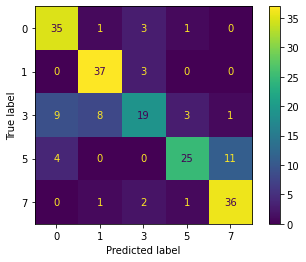

In [79]:
metrics.plot_confusion_matrix(knn_glcm_chi, glcm_test_flat, y_test);

#### Observaciones

Como se comentaba en el anterio caso, los resultados empleando esta distancia son buenos. Así pues, podría decirse que el hecho de que haya tantos ceros en histograma GLCM, y por lo tanto una menor capacidad descriptiva de la imagen, no influye tantísimo como se esperaba observando los valores de las anteriores métricas. Aún así son resultados peores que empleando los histogramas HOG. De nuevo, se vuelve a recalcar la idea de que las combinaciones de niveles de gris posibles entre clases no son tan diferentes como la forma de los objetos. Es por ello que es de esperar que el descriptor HOG proporcione una mayor capacidad discriminatoria que las GLCM. 

Por otra parte, sí que resulta mucho mejor en este caso emplear directamente los histogramas GLCM que las medidas de texturas, las cuales, por la poca cantidad de valores que se tienen de cada una de ellas por imagen, resultan insuficientes. 

### Empleando como métrica de distancia la Euclídea

In [80]:
knn_glcm_eu = KNeighborsClassifier() #default parameters

knn_glcm_eu = knn_glcm_eu.fit(glcm_train_flat, y_train)

In [81]:
prediction_glcm_eu = knn_glcm_eu.predict(glcm_test_flat)

In [82]:
acc_glcm_eu = metrics.accuracy_score(y_test, prediction_glcm_eu)
precision_glcm_eu = metrics.precision_score(y_test, prediction_glcm_eu, average = 'macro') 
recall_glcm_eu = metrics.recall_score(y_test, prediction_glcm_eu, average = 'macro')
f1_glcm_eu = metrics.f1_score(y_test, prediction_glcm_eu, average = 'macro')

print ('Accuracy: ', acc_glcm_eu, '\n',
       'Precision: ', precision_glcm_eu,'\n',
       'Recall: ', recall_glcm_eu, '\n', 
       'F1: ', f1_glcm_eu)

Accuracy:  0.66 
 Precision:  0.6510998122653318 
 Recall:  0.6599999999999999 
 F1:  0.6518023195609403


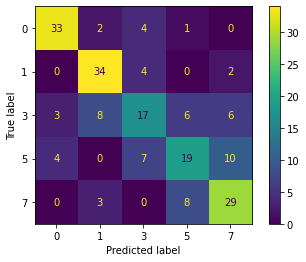

In [83]:
metrics.plot_confusion_matrix(knn_glcm_eu, glcm_test_flat, y_test);

#### Observaciones

En este caso se comprueba que la distancia Euclídea funciona peor que la Chi Square, la cual resulta la más apta para este tipo de descriptores en este problema, pero al menos no funciona tan mal como la de Bhattacharyya. 

## Conclusiones

1. Dada la naturaleza de las imágenes del problema, el decriptor que mejor parece discriminar entre artículos es el HOG con una _accuracy_ máxima del 94.5%. Esto puede deberse a que describe la forma del objeto, más que la textura de este, lo cual dado el problema resulta más diferenciador. El segundo mejor descriptor son los histogramas GLCM, alcanzando una _accuracy_ del 76%. Finalmente las medidas de textura proporcionan una clasificación pésima con un _accuracy_ máximo del 43.5% (4 medidas de textura).

2. Las distancias empleadas en el algoritmo KNN puede influir enormemente en los resultados. Así pues, para los descriptores HOG la mejor distancia resulta ser la de Bhattacharyya. Para los histogramas GLCM es la distancia Euclídea.

3. En este problema, la textura entre distintos artículos puede no cambiar mucho. Esto puede deberse principalmente a la monotonía en los niveles de gris y el reducido tamaño de las imágenes. Podría ser por ello que los decriptores relacionados con la textura funcionan peor en este problema. 